# Cancellation model_v1.X  (Enrolled after 1/1/2016, pulled 2020/03/13)
Joins with information about Cases and Twilio Calls, deals, and RI.  Will also add *PS*  
By Dequan Er  

03/17/2020

* update more negative samples, to ~100000 
* update bug graduation before start
* In this X version, it aims to develop tools and infurstractures for text features.
* should time allow, it will also investigate the LSTM model with sliced time period.

# Summary  
Create ML model to predict cancellation probability, both at Enrollment and ongoing throughout the client’s journey.  
1. feature selection and feature importance
2. model training
3. build infurstracture for further model with LSTM or CNN model.

In [330]:
# Usual imports
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam

import nltk
nltk.download('wordnet')
import re # DE add
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import string

from nltk.corpus import stopwords
from sklearn.manifold import TSNE

stop=set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dequan.er/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


write basic functions and set up data_pull_date and ytica_start_date.

In [324]:
# Setup initial variables, define functions

# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()

test_date_start = pd.to_datetime('2020-03-01')
test_date_end = pd.to_datetime('2020-03-07')

data_pull_date = pd.to_datetime('2020-03-13')
ytica_start_date = pd.to_datetime('2018-01-01')

# def lemmatize_text(text):
#     '''Conver text into list of lemmatized words'''
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
def check_date(date_str, Format):
    '''
    Parse datetime into integer.
    Format = 1: 'yyyy-mm-dd...'
    Format = 2: 'mm/dd/yyyy'
    '''
    if date_str == date_str:
        if Format == 1:
            y = int(date_str[0:4])*10000
            m = int(date_str[5:7])*100
            d = int(date_str[8:10])
        elif Format == 2:
            y = int(date_str[6:10])*10000
            m = int(date_str[0:2])*100
            d = int(date_str[3:5])
        else:
            print('Invalid Format: 1 for "yyyy-mm-dd", 2 for "mm/dd/yyyy"')
            return
    else:
        return np.nan
    
    if (m>0 and m<1201):
        return pd.to_datetime(str(y+m+d),format='%Y%m%d', errors='coerce')
    else: 
        return np.nan

def date_to_int(date_str, Format):
    '''
    Parse datetime into integer.
    Format = 1: 'yyyy-mm-dd...'
    Format = 2: 'mm/dd/yyyy'
    '''
    if date_str == date_str:
        if Format == 1:
            y = int(date_str[0:4])*10000
            m = int(date_str[5:7])*100
            d = int(date_str[8:10])
        elif Format == 2:
            y = int(date_str[6:10])*10000
            m = int(date_str[0:2])*100
            d = int(date_str[3:5])
        else:
            print('Invalid Format: 1 for "yyyy-mm-dd", 2 for "mm/dd/yyyy"')
            return
        return y+m+d
    else:
        return date_str
    
def plot_feature(df_view, feature, title, x_label, rot=0):
    '''
    Given a dataframe with bucketed feature, 
    plot Class dependence on the given feature
    '''
    df_view = df_view.sort_values(feature, ascending = True)
    plt.subplots(figsize = (15, 8))
    ax = sns.barplot(x = df_view[feature], y = df_view.Class, linewidth=2)
    plt.title(title, fontsize = 25)
    plt.ylabel("% of CCs Legal", fontsize = 15)
    plt.xlabel(x_label,fontsize = 15)
    plt.xticks(rotation = rot);
    #can display feature counts
    #display(df_view[feature].value_counts().sort_index())
    
def labelize(x, scale, limit=1000000000, exception=None, force=100):
    '''
    Bucket a feature into string ranges using floor(x/scale)*scale to determine buckets
    '''
    if force == 100:
        if x < limit:
            return str(int(np.floor(x/scale)*scale)) + "-" + \
                str(int(np.floor(x/scale)*scale + scale))
        else:
            return exception
    else:
        if x < limit:
            a = str(int(np.floor(x/scale)*scale))
            pad = force - len(a)
            a = "0"*pad + a
            b = str(int(np.floor(x/scale)*scale + scale))
            pad = force - len(b)
            b = "0"*pad + b
            return a + "-" + b
        else:
            return exception
        
def timeDiff(col,form,data):
    """
    Input: col of desired date different, date in format col[1]-col[0], arr
    Output: number of years or days
    Form: y for year, d for day, str
    data: the dataFrame to input
    """
    t1 = pd.to_datetime(data[col[0]],errors='coerce')
    t2 = pd.to_datetime(data[col[1]],errors='coerce')
    if form == ('y' or 'Y'):
        return (t2-t1).astype('timedelta64[Y]')
    if form == ('d' or 'D'):
        return (t2-t1).astype('timedelta64[D]')

In [325]:
df_deals = pd.read_csv('~/OneDrive - National Debt Relief/1-share_team/cancellation_model_v1.0/data_in/DS_update.csv')#,parse_dates = [2,3,9,13,-2])
# df_cases = pd.read_csv('data_in/Case.csv')
# df_calls = pd.read_csv('data_in/DS_Phone_Calls.csv') #,parse_dates = [1])
# df_RI = pd.read_csv('data_in/RI.csv',parse_dates = [0, 1])


In [326]:
df_deals['test_date_start'] = test_date_start
df_deals['test_date_end'] = test_date_end

xx = df_deals[timeDiff(['Final_Cancel_Date__c','test_date_end'],'d',df_deals)>=0]
df_test = xx[timeDiff(['test_date_start','Final_Cancel_Date__c'],'d',xx)>=0]

df_deals['WC_Date'] = df_deals['WC_Complete_Date_Time__c'].astype(str).str[:-18]
df_deals = df_deals.drop(columns='WC_Complete_Date_Time__c')



In [327]:
df_deals.shape, df_test.shape

((562893, 30), (1045, 30))

In [328]:
# Describe imported columns in each dataframe
dfs = [df_deals]#,df_cases,df_calls,df_RI]
for i in dfs:   
    print(i.columns)
df = df_deals.copy()

Index(['Id', 'Name', 'Final_Cancel_Date__c', 'Graduated_Date__c', 'Signed__c',
       'Applicant_s_Take_home_Pay__c', 'Client_State__c', 'Enrollment_Date__c',
       'FICO_Experian_At_Enrollment__c',
       'FICO_Experian_At_Enrollment_CoClient__c', 'Hardship__c',
       'Monthly_Payment__c', 'Program_Type__c', 'Rent_Renter_s_Insurance__c',
       'State_at_Enrollment__c', 'Total_Monthly_Expense__c',
       'Total_Monthly_Income__c', 'Vehicle_Payments__c',
       'Waiver_Aggressive_Creditor__c', 'Waiver_Business_Debt__c',
       'Waiver_CU_USAA__c', 'Waiver_Good_Faith_High_Risk__c',
       'Waiver_Military__c', 'Waiver_PayDay_Loans__c',
       'Waiver_Secured_Accounts__c', 'Waiver_Single_Account__c',
       'Welcome_Call_Timer_Report__c', 'test_date_start', 'test_date_end',
       'WC_Date'],
      dtype='object')


Check the data shape. 

In [332]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    '''Conver text into list of lemmatized words'''
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


print('Cleaning Text')
df['Hardship__c'] = df['Hardship__c'].str.lower()
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r'\n\s?[0-9]{1,2}[\/:,.-][0-9]{1,2}[\/:,.-][0-9]{1,2}.*',' ',x) if x == x else '')
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r'\n',' ',x) if x == x else '')
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r"'",'',x) if x == x else '')
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r'\b\w\b',' ',x) if x == x else '')
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r'[^a-zA-Z]', ' ',x) if x == x else '')
df['Hardship__c'] = df['Hardship__c'].map(lambda x: re.sub(r'\bnc\b.*', ' ',x) if x == x else '')
print('Parsing words')
df['Hardship__c'] = df['Hardship__c'].apply(lemmatize_text)
df['Hardship__c'] = df['Hardship__c'].map(lambda x: ' '.join(x))

Cleaning Text
Parsing words


In [337]:
df['Class'] = df['Final_Cancel_Date__c'].apply(lambda x: True if x == x else False)

In [338]:
df = df[['Name','Hardship__c','Class']].iloc[:2000]

In [339]:
df = df.dropna()
df['Hardship__c']=df['Hardship__c'].apply(lambda x: str(x))

In [340]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"
# print(remove_URL(example))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# example = """<div>
# <h1>Real or Fake</h1>
# <p>Kaggle </p>
# <a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
# </div>"""

# print(remove_html(example))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove_emoji("Omg another Earthquake 😔😔")

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

# example="I am a #king"
# print(remove_punct(example))

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
# text = "corect me plese"
# correct_spellings(text)

# df['text']=df['Hardship__c'].apply(lambda x: remove_emoji(x))
# df['text']=df['Hardship__c'].apply(lambda x: remove_html(x))
# df['text']=df['Hardship__c'].apply(lambda x: remove_URL(x))
df['text']=df['Hardship__c'].apply(lambda x: remove_punct(x))
df['text']=df['Hardship__c'].apply(lambda x: correct_spellings(x))



In [341]:
# df= df.dropna()
# df = df[df.Hardship__c.apply(lambda x: x !="")]

In [342]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        

In [343]:
corpus=create_corpus(df)

100%|██████████| 2000/2000 [00:00<00:00, 6533.51it/s]


In [282]:
embedding_dict={}
with open('../../Downloads/glove.6B/glove.6B.50d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [283]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [284]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 4479


In [285]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,50))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 4479/4479 [00:00<00:00, 593713.66it/s]


In [310]:
model=Sequential()

embedding=Embedding(num_words,50,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [311]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           224000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 100, 50)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 315,777
Trainable params: 91,777
Non-trainable params: 224,000
_________________________________________________________________


In [352]:
df_work = df[['Class','text']]

In [356]:
train=tweet_pad[:1000]
test=tweet_pad[1000:]

In [318]:
X_train,X_test,y_train,y_test=train_test_split(train,df['Class'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (1053, 100)
Shape of Validation  (186, 100)


In [344]:
history=model.fit(X_train,y_train,batch_size=8,epochs=20,validation_data=(X_test,y_test),verbose=2)

Train on 1053 samples, validate on 186 samples
Epoch 1/50
 - 4s - loss: 0.5621 - accuracy: 0.7559 - val_loss: 0.5670 - val_accuracy: 0.7527
Epoch 2/50
 - 5s - loss: 0.5546 - accuracy: 0.7559 - val_loss: 0.5672 - val_accuracy: 0.7527
Epoch 3/50
 - 5s - loss: 0.5548 - accuracy: 0.7559 - val_loss: 0.5670 - val_accuracy: 0.7527
Epoch 4/50
 - 5s - loss: 0.5642 - accuracy: 0.7559 - val_loss: 0.5677 - val_accuracy: 0.7527
Epoch 5/50
 - 5s - loss: 0.5574 - accuracy: 0.7559 - val_loss: 0.5673 - val_accuracy: 0.7527
Epoch 6/50
 - 5s - loss: 0.5608 - accuracy: 0.7559 - val_loss: 0.5680 - val_accuracy: 0.7527
Epoch 7/50
 - 5s - loss: 0.5555 - accuracy: 0.7559 - val_loss: 0.5676 - val_accuracy: 0.7527
Epoch 8/50
 - 5s - loss: 0.5680 - accuracy: 0.7559 - val_loss: 0.5682 - val_accuracy: 0.7527
Epoch 9/50
 - 5s - loss: 0.5591 - accuracy: 0.7559 - val_loss: 0.5682 - val_accuracy: 0.7527
Epoch 10/50
 - 5s - loss: 0.5532 - accuracy: 0.7559 - val_loss: 0.5675 - val_accuracy: 0.7527
Epoch 11/50
 - 5s - lo

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


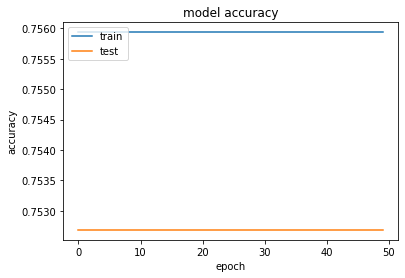

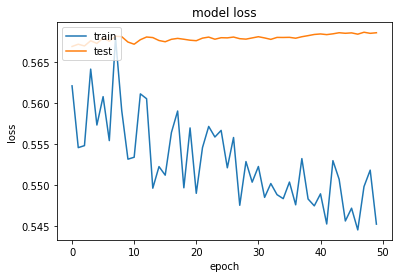

In [345]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [358]:
y_pre=model.predict(test)

In [360]:
(y_pre>0.5).sum()

0

In [363]:
y_pre

array([[0.20830883],
       [0.23879205],
       [0.23509656],
       [0.26572496],
       [0.25505364],
       [0.26802725],
       [0.26324806],
       [0.25876102],
       [0.06761529],
       [0.26599842],
       [0.08680558],
       [0.26595438],
       [0.09740067],
       [0.26919112],
       [0.08803725],
       [0.24821974],
       [0.23833   ],
       [0.22998682],
       [0.26841283],
       [0.07679735],
       [0.07960746],
       [0.2495461 ],
       [0.26773447],
       [0.26919717],
       [0.26649413],
       [0.26757455],
       [0.26567936],
       [0.26744658],
       [0.26787075],
       [0.26770037],
       [0.2670454 ],
       [0.20027125],
       [0.26405314],
       [0.24204595],
       [0.26286677],
       [0.26690623],
       [0.21734855],
       [0.26483238],
       [0.26410952],
       [0.20455869],
       [0.26927435],
       [0.26191902],
       [0.23712891],
       [0.15088312],
       [0.0986115 ],
       [0.2594641 ],
       [0.25993395],
       [0.257